In [1]:
# if necessary, install NeuralGCM and dependencies
! pip install -q -U neuralgcm dinosaur-dycore gcsfs

# Forecasting quick start

This notebook uses ERA5 data and pretrained NeuralGCM model to make a weather forecast.

The forecast is made in 3 steps:
1. Slice of ERA5 data is regridded to model resolution
2. NeuralGCM model state is initialized and rolled out
3. Predictions and reference trajectory are combined for visualization

By default the notebook uses intermediate deterministic NeuralGCM 1.4° model. Other available checkpoints include deterministic 0.7°, 2.8° and stochastic 1.4° NeuralGCM variations.

```{tip}
You can run this notebook yourself in [Google Colab](https://colab.research.google.com/github/google-research/neuralgcm/blob/main/docs/inference_demo.ipynb). We recommend using a GPU or TPU runtime due to high memory and compute requirements.
```

In [2]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

gcs = gcsfs.GCSFileSystem(token="anon")

## Load a pre-trained NeuralGCM model

```{caution}
Trained model weights are licensed for non-commercial use, under the Creative Commons [Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/) license (CC BY-NC-SA 4.0).
```

Pre-trained model checkpoints from the NeuralGCM paper are [available for download](https://console.cloud.google.com/storage/browser/gresearch/neuralgcm/04_30_2024) on Google Cloud Storage:

- Deterministic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl`
- Stochastic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl`



In [3]:
model_name = "neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl"  # @param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

with gcs.open(f"gs://gresearch/neuralgcm/04_30_2024/{model_name}", "rb") as f:
    ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

## Load ERA5 data from GCP/Zarr

See {doc}`datasets` for details.

Select out a few days of data:

In [4]:
era5_path = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

demo_start_time = "2020-02-14"
demo_end_time = "2020-02-18"
data_inner_steps = 24  # process every 24th hour

sliced_era5 = (
    full_era5[model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift="24 hours",
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

Regrid to NeuralGCM's native resolution:

In [5]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes["latitude"],
    longitude_nodes=full_era5.sizes["longitude"],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

## Make the forecast

See {doc}`trained_models` for details.

In [6]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, "h") * inner_steps
times = np.arange(outer_steps) * inner_steps  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
predictions_ds = model.data_to_xarray(predictions, times=times)

## Compare forecast to ERA5

See [WeatherBench2](https://sites.research.google/weatherbench/) for more comprehensive evaluations and archived NeuralGCM forecasts.

In [7]:
# error("Stop here.")

NameError: name 'error' is not defined

In [9]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5.thin(time=(inner_steps // data_inner_steps)).isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times)

combined_ds = xarray.concat([target_data_ds, predictions_ds], "model")
combined_ds.coords["model"] = ["ERA5", "NeuralGCM"]

In [10]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.specific_humidity.sel(level=850).plot(
    x="longitude", y="latitude", row="time", col="model", robust=True, aspect=2, size=2
)

## Sensitivity to local perturbations

In [72]:
# options for variables to perturb
print(eval_era5.data_vars)

Data variables:
    geopotential                         (time, level, longitude, latitude) float32 6MB ...
    specific_humidity                    (time, level, longitude, latitude) float32 6MB ...
    temperature                          (time, level, longitude, latitude) float32 6MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 6MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 6MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 6MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 6MB ...
    sea_ice_cover                        (time, longitude, latitude) float32 164kB ...
    sea_surface_temperature              (time, longitude, latitude) float32 164kB ...


In [62]:
lev = 1000
delta_var = "temperature"
lat_pt = 45.0
lon_pt = 180.0

ilev = np.argmin(np.abs(eval_era5["level"].values - lev)).item()
ilat = np.argmin(np.abs(eval_era5["latitude"].values - lat_pt))
ilon = np.argmin(np.abs(eval_era5["longitude"].values - lon_pt))

print(f'Perturbation being added at level {lev} hPa, latitude {lat_pt}°, longitude {lon_pt}°')

Perturbation being added at level 1000 hPa, latitude 45.0°, longitude 180.0°


In [65]:
import time

predictions_dict = {}

for perturbation in (0, 2, 5):
    print(f"Running perturbation delta_{perturbation}")

    start_time = time.time()

    # get inputs and add perturbation to 1000 hPa temperature
    inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
    inputs[delta_var][ilev, ilon, ilat] = (
        inputs[delta_var][ilev, ilon, ilat] + perturbation
    )

    # initialize model state
    input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
    rng_key = jax.random.key(42)  # optional for deterministic models
    initial_state = model.encode(inputs, input_forcings, rng_key)

    # use persistence for forcing variables (SST and sea ice cover)
    all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

    # make forecast
    final_state, predictions = model.unroll(
        initial_state,
        all_forcings,
        steps=outer_steps,
        timedelta=timedelta,
        start_with_input=True,
    )

    predictions_dict[f"delta_{perturbation}"] = (
        model.data_to_xarray(predictions, times=times)
        .sel(level=[1000, 850, 500])
        .load()
    )

    print(f"   elapsed time: {time.time() - start_time:.2f} seconds")

Running perturbation delta_0
   elapsed time: 180.10 seconds
Running perturbation delta_2
   elapsed time: 180.29 seconds
Running perturbation delta_5
   elapsed time: 180.56 seconds


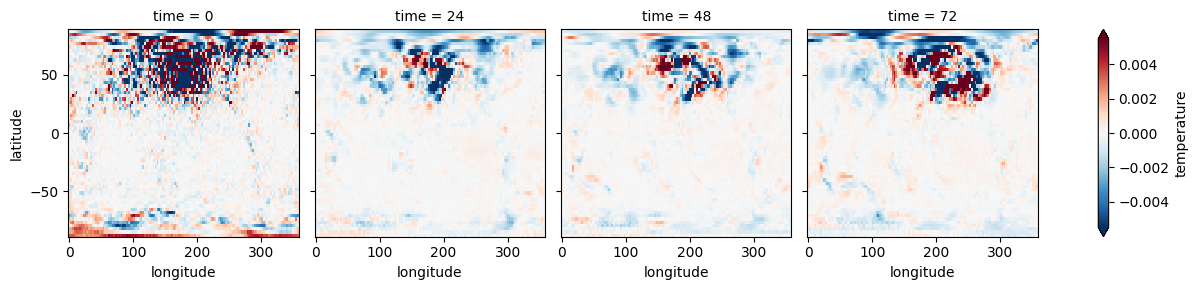

In [78]:
var = "temperature"
level = 1000

diff_ds = predictions_dict["delta_5"][var].sel(level=level) - predictions_dict["delta_0"][var].sel(level=level)
diff_ds.plot(x="longitude", y="latitude", col="time", col_wrap=4, robust=True, cmap="RdBu_r")